# Recurrent Neural Networks (RNN)

In this homework, we will work with Recurrent Neural Networks (RNN). An RNN is a class of neural networks where the output not only depends on the current input but also on previous inputs along a given input sequence. This allows exhibiting temporal dynamic behavior and contextual information in a sequence. Common applications for RNN are:

- time-series analysis
- speech recognition
- machine translation
- image captioning
- sentiment analysis


## 0. Goal of this homework

This notebook should help you to experiment with how recurrent neural networks are implemented. Therefore, this notebook is structured as follows:
1. Check out our implementation of a simple RNN class in Pytorch.
2. Explore the back-propagation of the gradients in the RNN and discuss the vanishing gradient problem.
3. Implement your LSTM (Long-Short Term Memory) Network and show that this architecture improves the vanishing gradient problem.
4. Learn how to deal with different length sequences in the same batch.


## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "DL_homeworks" within your main drive folder, and put the homework there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct homework folder (e.g homework_10) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/DL_homeworks/homework_10'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

As always, we first import some packages to setup the notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import os

device = torch.device("mps:0" if torch.backends.mps.is_available() else "cpu")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
import platform
print('Using python: ', platform.python_version())
print('Using torch version: ', torch.__version__)
print('Using device: ', device)
# Machine: 2015 13" Macbook Pro, i5 dual core

Using python:  3.10.13
Using torch version:  2.1.0
Using device:  mps:0


## 1. Simple Recurrent Neural Network

The recurrent loops in an RNN allow relevant information to persist over time. A simple RNN architecture is shown here:
<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-rolled.png width="150">

A simple RNN takes not only an input `X` at time step `t` but also passes a hidden state that is the output of the previous time step into the network. The output of an RNN cell at time step `t` is computed as follows (the biases have been omitted for simplicity):

![](https://drive.google.com/uc?export=view&id=1bIg8POw5FSOA59jQ2b_vzkzsIfZRKK-S)

<div class="alert alert-success">
    <h3>Task: Check Code</h3>

<p>In this task, you will to learn how to implement a simple one-layer RNN as a class in Pytorch by checking the code we provide to you.</p>
    
<p>Check <code>exercise_code/rnn/rnn_nn.py</code> where we defined a naive <code>RNN</code> cell you see in the image below. The vanilla RNN transforms inputs and hidden states with a single linear layer followed by a <code>tanh</code> or <code>relu</code> activation.
</p>

</div>

<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png width="600">

Luckily, Pytorch already has implemented a simple RNN in their library and you can call the RNN with <code>nn.RNN</code>. We will use the Pytorch RNN function to check if our implementation is correct and compare the output of both functions.

In [3]:
import torch.nn as nn
import timeit

from exercise_code.rnn.rnn_nn import RNN
from exercise_code.rnn.tests import rnn_output_test

# choose your network parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_rnn = nn.RNN(input_size, hidden_dim)
our_rnn = RNN(input_size, hidden_dim)
x = torch.randn((seq_len, 1, input_size))

rnn_output_test(our_rnn, pytorch_rnn, x)

Output shape test passed, torch.Size([10, 1, 3]) == torch.Size([10, 1, 3])
Hidden shape test passed, torch.Size([1, 1, 3]) == torch.Size([1, 1, 3])

Difference between pytorch and your RNN implementation for 'h_seq': 0.00
Congrats, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'h': 0.00
Congrats, you implemented a correct model.


True

Our implementation is thus correct and working similarly to the Pytorch implementation. You probably already expected this. But let us show you something that might be more interesting when we compare our implementation to the Pytorch implementation. Therefore let us check out the running time of both classes: 

In [4]:
import timeit
runs=10**4


print("Time Pytorch RNN {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_rnn(x)", 
                                       setup="from __main__ import pytorch_rnn, x", 
                                       number=runs))
     )

print("Time Our RNN {} run: {:.3f}s".format(runs, timeit.timeit("our_rnn(x)", 
                                       setup="from __main__ import our_rnn, x", 
                                       number=runs))
     )

Time Pytorch RNN 10000 runs: 0.969s
Time Our RNN 10000 run: 2.226s


You can see that the Pytorch module is faster and optimized in performance. Let us agree from now on to use the Pytorch module for an RNN since this will lead to better performances. However, it is always a good exercise to build the functions by yourself and we really advise you to check out the implementation.

### 2.1. Vanishing Gradient

As discussed in the lecture, the simple RNN suffers from vanishing gradients in the back-propagation. The hidden state is manipulated in every time step along the sequence and the effect of the past inputs to the final output vanishes with the distance in time. In the next cell, we will explore the vanishing effect of previous inputs in the RNN.

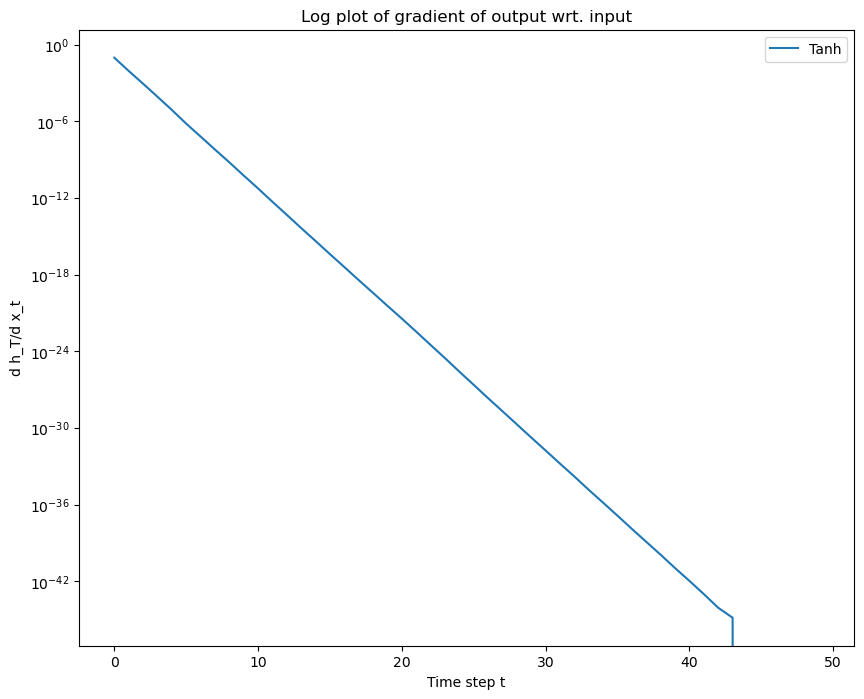

In [5]:
hidden_size=1
input_size= 1

time_steps=50
rnn = RNN(input_size, hidden_size, 'tanh')

for p in rnn.parameters():
    p.data.fill_(0.1)

x = torch.randn(time_steps, 1, input_size)
x.requires_grad=True
_, h = rnn(x)
h.requires_grad
h.sum().backward()
grad_tanh=x.grad.view(-1)

plt.semilogy(np.flip(abs(grad_tanh.detach().cpu().numpy())), label="Tanh")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show() 

<div class="alert alert-warning">
    <h3>Note</h3>
    <p>It can be seen that the gradient of the of the output at time <code>t</code> with respect to to a previous input decreases exponentially. Hence, the final output does not change significantly for changes in the previous input and hence the RNN does not have memory.</p> 
<h3>Task</h3> 
<p>In order to better understand the vanishing gradient problem, calculate the gradients <code>dh_t/dW_hh</code>, <code>dh_t /dW_xh</code>, and <code>dh_t/dx_0</code> analytically for <code>t=3</code> and <code>h_0=0</code> using the formula (Update Hidden State) from above. This exercise might seem a little bit tedious but it is really useful. Can you explain the vanishing gradient mathematically based on your findings?</p>
</div>

## 3. Long-Short Term Memory Network (LSTM)
The vanishing gradient problem had been known for some time until Schmidhuber (1997) developed the Long-Short Term Memory Network and showed that this architecture can overcome the problem. <br>
An LSTM is a more advanced recurrent network architecture that can learn long time dependencies. The architecture of an LSTM is composed of a forget, input and output gate and the cell can remember values over arbitrary time intervals. The standard LSTM cell is shown in the figure below:


<img src=http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png width="600">


<img src=https://miro.medium.com/max/1400/1*-kBdBYzR7lpimgb3AIRkOw.png width="400">

Compared to a simple RNN the LSTM cell has a hidden vector and an additional cell state vector. __What size does the cell state have?__ <br>


The operations inside the LSTM are given as 


<img src=https://wikimedia.org/api/rest_v1/media/math/render/svg/2db2cba6a0d878e13932fa27ce6f3fb71ad99cf1  width="400" align="left">

<div class="alert alert-info">
    <h3> Task: Implement LSTM </h3>
    Now, it is your turn. Implement your own LSTM with the operations stated above. Go to <code>exercise_code/rnn/rnn_nn.py</code> and complete the implementation of the <code>LSTM</code> class.
</div>

When you are done with the task, the following cell will check whether your implementation has been correct. Similar to the RNN, Pytorch of course also provides an implementation for a LSTM which can be called with `nn.LSTM`.

In [6]:
# TODO: Implement the LSTM class
from exercise_code.rnn.rnn_nn import LSTM

# choose your input parameters
input_size=3
hidden_dim=3
seq_len= 10 

# define the two models
pytorch_lstm = nn.LSTM(input_size, hidden_dim)
our_lstm = LSTM(input_size, hidden_dim)

x = torch.randn(seq_len, 1, input_size)
rnn_output_test(our_lstm, pytorch_lstm, x)

Output shape test passed, torch.Size([10, 1, 3]) == torch.Size([10, 1, 3])
Hidden shape test passed, torch.Size([1, 1, 3]) == torch.Size([1, 1, 3])

Difference between pytorch and your RNN implementation for 'h_seq': 0.00
Congrats, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'h': 0.00
Congrats, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'c': 0.00
Congrats, you implemented a correct model.


True

Congratulations, if the test above has been successful, you implemented your LSTM correctly. Of course, this task is meant to pratice your understanding on the LSTM architecture. In future,  you can better use the Pytorch implementation as this will probably be faster and optimized in performance. Let us check that out:

In [7]:
import timeit
runs=10**4

print("Time Pytorch LSTM {} runs: {:.3f}s".format(runs, timeit.timeit("pytorch_lstm(x)", 
                                       setup="from __main__ import pytorch_lstm, x", 
                                       number=runs))
     )

print("Time Our LSTM {} runs: {:.3f}s".format(runs, timeit.timeit("our_lstm(x)", 
                                       setup="from __main__ import our_lstm, x", 
                                       number=runs))
     )

Time Pytorch LSTM 10000 runs: 2.383s
Time Our LSTM 10000 runs: 9.131s


### 3.1 Explore Gradients
Analogously to the RNN, calculate the gradients of the input wrt. to the output of the LSTM and compare it against the RNN gradients. __What do you see?__


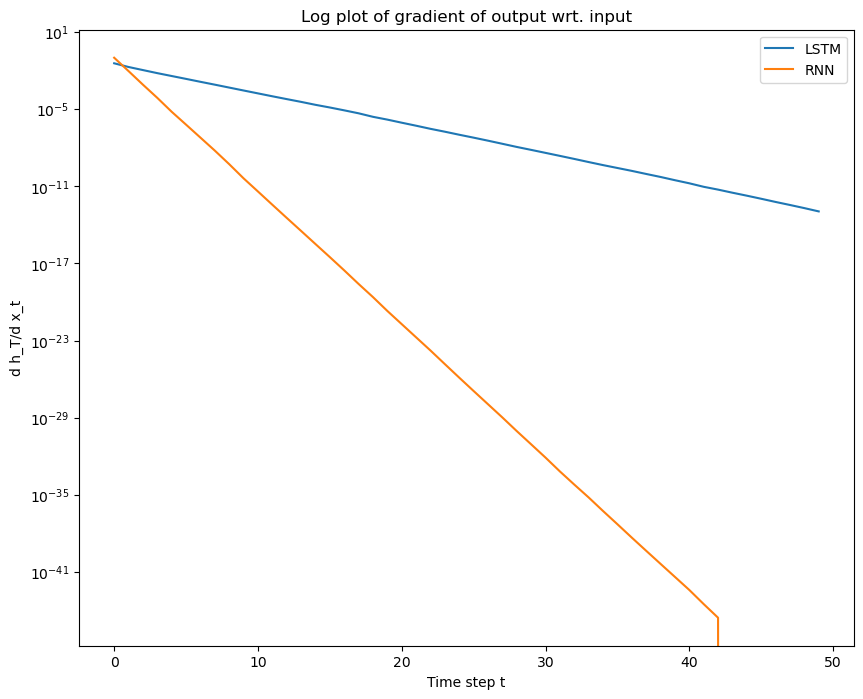

In [8]:
hidden_size = 1
input_size = 1

time_steps=50
rnn = RNN(input_size, hidden_size)
for p in rnn.parameters():
    p.data.fill_(0.1)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad = True
_,h = rnn(X)
h.requires_grad
h.sum().backward()
grad_rnn = X.grad.view(-1)

lstm = LSTM(input_size, hidden_size)
for p in lstm.parameters():
    p.data.fill_(0.1)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad=True
_,(h, c) = lstm(X)
h.sum().backward()
grad_lstm = X.grad.view(-1)

plt.semilogy(np.flip(abs(grad_lstm.detach().cpu().numpy())) , label="LSTM")
plt.semilogy(np.flip(abs(grad_rnn.detach().cpu().numpy())), label="RNN")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show() 


## 4. Exploding Gradients Problem

In the previous sections, we addressed the vanishing gradients problem by switching from vanilla RNNs to LSTMs.

The vanishing gradient problem occurs when weights are smaller 1. When weights are bigger than 1, we have another problem called the <b>exploding gradient</b>, where gradients end up getting very large values. This can be observed best with the `relu` RNN cells.

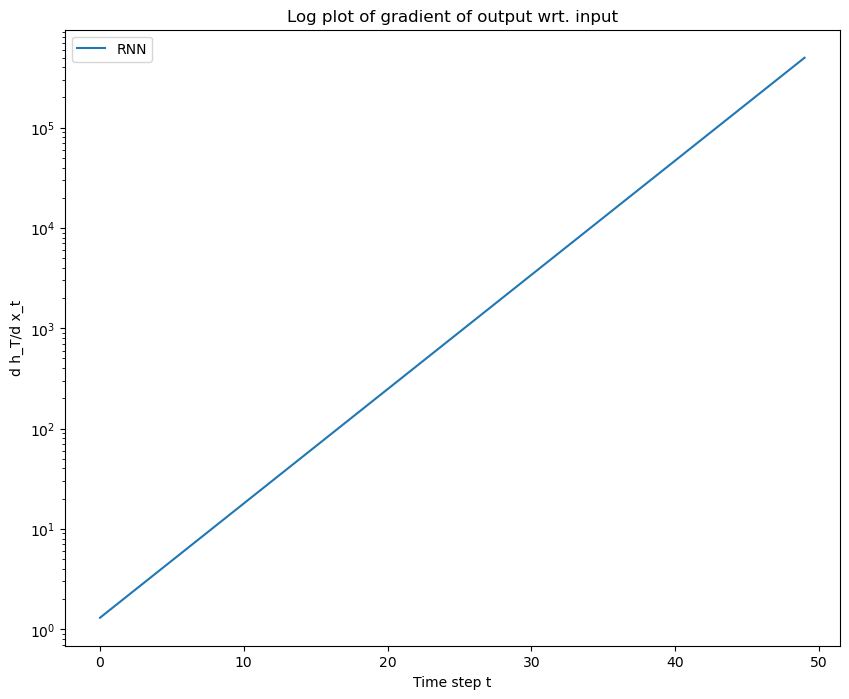

In [9]:
hidden_size = 1
input_size = 1

time_steps=50
rnn = RNN(input_size, hidden_size, activation='relu')
for p in rnn.parameters():
    p.data.fill_(1.3)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad = True
_,h = rnn(X)
h.requires_grad
h.sum().backward()
grad_rnn = X.grad.view(-1)  # next(rnn.parameters()).grad.view(-1)

plt.semilogy(np.flip(abs(grad_rnn.detach().cpu().numpy())), label="RNN")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show()

One possible solution of this problem is gradient clipping. Gradient clipping shrinks gradient magnitude. We can use [clip_grad_norm_](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html) function from PyTorch here. Observe the gradient magnitude is smaller.

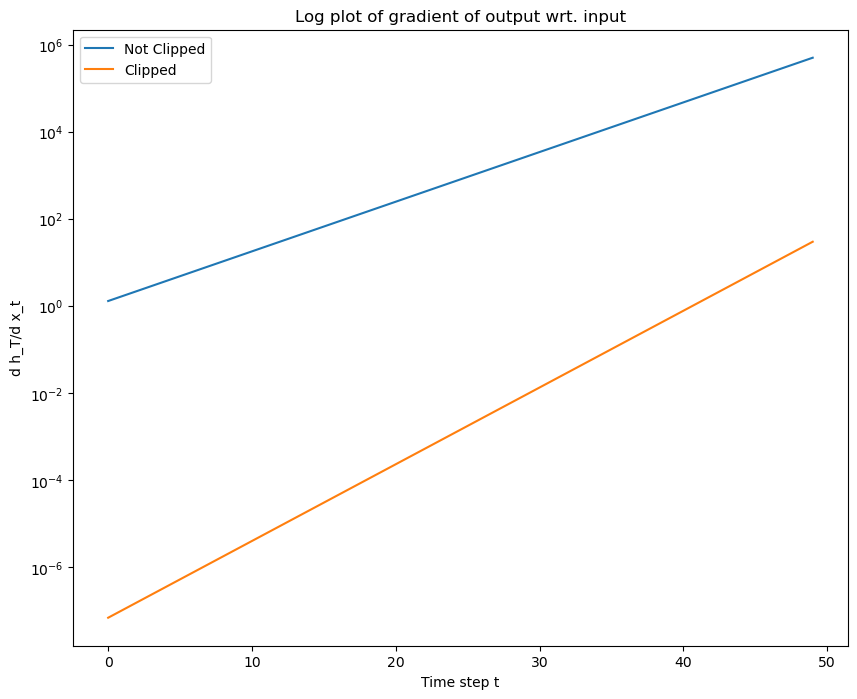

In [10]:
from torch.nn.utils import clip_grad_norm_

grad_rnn_unclipped = grad_rnn.clone()

hidden_size = 1
input_size = 1
gclip = 40

time_steps=50
rnn = RNN(input_size, hidden_size, activation='relu')
for p in rnn.parameters():
    p.data.fill_(1.5)
X = torch.randn(time_steps, 1, input_size)
X.requires_grad = True
_,h = rnn(X)
h.requires_grad
h.sum().backward()
clip_grad_norm_(X, gclip)
grad_rnn = X.grad.view(-1)  # next(rnn.parameters()).grad.view(-1)

plt.semilogy(np.flip(abs(grad_rnn_unclipped.detach().cpu().numpy())), label="Not Clipped")
plt.semilogy(np.flip(abs(grad_rnn.detach().cpu().numpy())), label="Clipped")
plt.legend()
plt.xlabel("Time step t")
plt.ylabel("d h_T/d x_t")
plt.title("Log plot of gradient of output wrt. input")
plt.show()

## 5. Handling Batches with Different Sequence Lenghts

Sequences used in natural language processing tasks usually have different lengths. Unlike images, we cannot guarantee sequences to have the same shape. Therefore, we need to use <b>padding</b> and <b>packing</b>. PyTorch provides some operations for that. Before moving forward, see the documentations of [pack_padded_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html) and [pad_packed_sequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_packed_sequence.html) functions.

In this section, you don't have to implement anything. You should just understand how we handled the mini-batches with varying length sequences.

Let's import the relevant functions first.

In [11]:
from torch.nn.utils.rnn import (
    pack_padded_sequence,
    pad_packed_sequence
)

We represent a padded sequence with a tensor of size `(max_len, batch_size, feature_size)` and a 1d lengths tensor of size `batch_size`. 

As an example, tensors below mean we have 2 sequences of lengths 3 and 2. Therefore, the elements `padded_seq[2, 1, :]` are paddings whose values we should ignore.

In [12]:
padded_seq = torch.arange(0, 12).view(3, 2, 2).float()
lengths = torch.tensor([3, 2]).long()

padded_seq, lengths

(tensor([[[ 0.,  1.],
          [ 2.,  3.]],
 
         [[ 4.,  5.],
          [ 6.,  7.]],
 
         [[ 8.,  9.],
          [10., 11.]]]),
 tensor([3, 2]))

PyTorch RNNs internally use the [PackedSequence](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.PackedSequence.html) to store and process batches with varying length sequences:

In [13]:
packed_seq = pack_padded_sequence(padded_seq, lengths)
packed_seq

PackedSequence(data=tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.],
        [8., 9.]]), batch_sizes=tensor([2, 2, 1]), sorted_indices=None, unsorted_indices=None)

`PackedSequence` is an internal representation PyTorch uses, about whom you can learn more about reading the PyTorch documentation. The packing can be inverted as follows, zeroing out the padded values:

In [14]:
pad_packed_sequence(packed_seq)

(tensor([[[0., 1.],
          [2., 3.]],
 
         [[4., 5.],
          [6., 7.]],
 
         [[8., 9.],
          [0., 0.]]]),
 tensor([3, 2]))

<div class="alert alert-success">
    <h3>Task: Check Code</h3>
<p>For convenience, we use padded representation in our RNN implementations and then ignore padded output. Check the <code>forward</code> functions of <code>RNN</code> and <code>LSTM</code> classes in <code>exercise_code/rnn/rnn_nn.py</code>. </p>
    
<p>For packed inputs, we switched to padded representation using <code>pad_packed_sequence</code>. In the end, we used the <code>pack_outputs</code> function to remain consistent with PyTorch.</p>
</div>

You can see that our implementation behaves identically to PyTorch RNNs.

In [15]:
torch_lstm = nn.LSTM(2, 2)
our_lstm = LSTM(2, 2)

rnn_output_test(our_lstm, torch_lstm, packed_seq)

Output shape test passed, torch.Size([5, 2]) == torch.Size([5, 2])
Hidden shape test passed, torch.Size([1, 2, 2]) == torch.Size([1, 2, 2])

Difference between pytorch and your RNN implementation for 'h_seq': 0.00
Congrats, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'h': 0.00
Congrats, you implemented a correct model.

Difference between pytorch and your RNN implementation for 'c': 0.00
Congrats, you implemented a correct model.


True

You have now completed the notebook on RNNs and LSTMs. You should be well prepared for the task on Sentiment Analysis which is described in the other two notebooks.